In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 48kB/s 


In [ ]:
!pip install keras-unet

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
## Imports
import os
import sys
import random
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=6, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
       

    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, str(id_name), "image", str(id_name)) + ".tif"
        mask_path = os.path.join(self.path, str(id_name), "mask", str(id_name)) + ".tif"
        
        ## Reading Image
        image = cv2.imread(image_path,cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)                 # image resize pahle kardi baad me dekhta hu
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        #(b, g, r)=cv2.split(image)
        #image=cv2.merge([r,g,b])
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        
        #print(image.shape)
        #(b, g, r)=cv2.split(mask)
        #mask=cv2.merge([r,g,b])
        mask = cv2.resize(mask,(self.image_size, self.image_size))
        mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
        image= image/255.0
        mask = mask/255.0
        
        return image, mask
    #newly inserted

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask 

# after newly
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))    
      
    
    

In [ ]:
class Test_DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=6, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
       

    def __load__(self, id_name):
        ## Path
        
        tst_img_pth = os.path.join(self.path, id_name)
        
        ## Reading Image
        tst_img = cv2.imread(tst_img_pth,cv2.IMREAD_UNCHANGED)
        tst_img = cv2.cvtColor(tst_img,cv2.COLOR_BGR2RGB)
        tst_img= cv2.resize(tst_img,(self.image_size, self.image_size))           
        tst_img = tst_img/255.0
        return tst_img
    #newly inserted

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        tst_img = []
        
        for id_name in files_batch:
            _tst_img = self.__load__(id_name)
            tst_img.append(_tst_img)
            
        tst_img= np.array(tst_img)
        return tst_img  

# after newly
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))    
      
    
    

In [ ]:
image_size = 128
train_path = "/content/drive/MyDrive/stage1/train/"    
test_path = "/content/drive/MyDrive/stage1/test/"    
epochs = 61
batch_size = 6

## Training Ids
train_ids = next(os.walk(train_path))[1]
test_ids = os.listdir(test_path)
print(train_ids[0])
print(train_path)
## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

99
/content/drive/MyDrive/stage1/train/


In [ ]:
print(test_ids)
print(train_ids)

['55.tif', '302.tif', '333.tif', '182.tif', '412.tif', '134.tif', '21.tif', '379.tif', '136.tif', '81.tif', '123.tif', '351.tif', '368.tif', '327.tif', '326.tif', '383.tif', '172.tif', '324.tif', '341.tif', '52.tif', '132.tif', '152.tif', '385.tif', '281.tif', '157.tif', '125.tif', '209.tif', '304.tif', '312.tif', '218.tif', '308.tif', '272.tif', '373.tif', '345.tif', '293.tif']
['85', '87', '89', '88', '82', '83', '80', '84', '9', '86', '73', '71', '78', '74', '72', '76', '79', '75', '77', '8', '67', '64', '65', '63', '69', '66', '70', '7', '68', '62', '57', '59', '6', '53', '56', '61', '58', '54', '50', '51', '48', '44', '49', '427', '46', '5', '428', '47', '43', '45', '423', '425', '421', '418', '420', '422', '426', '424', '42', '419', '411', '415', '413', '408', '417', '41', '407', '410', '414', '416', '405', '403', '400', '4', '399', '404', '40', '402', '401', '406', '390', '39', '397', '398', '395', '394', '389', '393', '388', '391', '38', '386', '375', '380', '377', '378', '381'

In [ ]:
y = DataGen(train_ids,train_path)
y.__load__(0)



(array([[[0.47843137, 0.47843137, 0.47843137],
         [0.50588235, 0.50588235, 0.50588235],
         [0.53333333, 0.53333333, 0.53333333],
         ...,
         [0.69411765, 0.69411765, 0.69411765],
         [0.71764706, 0.71372549, 0.70588235],
         [0.7372549 , 0.72156863, 0.70980392]],
 
        [[0.48627451, 0.48627451, 0.48627451],
         [0.51764706, 0.51764706, 0.51764706],
         [0.54509804, 0.54509804, 0.54509804],
         ...,
         [0.70980392, 0.70980392, 0.70980392],
         [0.76078431, 0.75294118, 0.74509804],
         [0.77254902, 0.75686275, 0.74509804]],
 
        [[0.49019608, 0.49019608, 0.49019608],
         [0.5372549 , 0.5372549 , 0.5372549 ],
         [0.55686275, 0.55686275, 0.55686275],
         ...,
         [0.71764706, 0.71764706, 0.71764706],
         [0.77647059, 0.77254902, 0.76470588],
         [0.8       , 0.78431373, 0.77254902]],
 
        ...,
 
        [[0.6627451 , 0.6745098 , 0.69411765],
         [0.69019608, 0.70196078, 0.72156

In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(6, 128, 128, 3) (6, 128, 128, 3)


In [ ]:
test_gen = Test_DataGen(test_ids, test_path,1)
x_test= test_gen.__getitem__(1)
print(x_test.shape)

(1, 128, 128, 3)


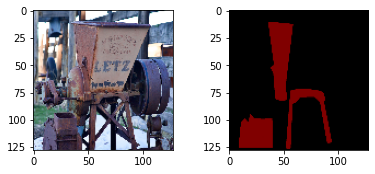

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r],(image_size, image_size,3),order='F'), cmap="gray")

In [ ]:
print(r)

1


In [ ]:
print(y[r].shape)

(128, 128, 3)


In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
t=UNet()

print(t.outputs)

[<KerasTensor: shape=(None, 128, 128, 1) dtype=float32 (created by layer 'conv2d_18')>]


In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [ ]:

train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/61
61/61 [==============================] - 721s 11s/step - loss: 0.2741 - acc: 0.9443 - val_loss: 0.0930 - val_acc: 0.9648
Epoch 2/61
61/61 [==============================] - 8s 124ms/step - loss: 0.1055 - acc: 0.9545 - val_loss: 0.0806 - val_acc: 0.9678
Epoch 3/61
61/61 [==============================] - 7s 119ms/step - loss: 0.1258 - acc: 0.9427 - val_loss: 0.0814 - val_acc: 0.9678
Epoch 4/61
61/61 [==============================] - 7s 118ms/step - loss: 0.1019 - acc: 0.9532 - val_loss: 0.0773 - val_acc: 0.9678
Epoch 5/61
61/61 [==============================] - 7s 118ms/step - loss: 0.1083 - acc: 0.9486 - val_loss: 0.0882 - val_acc: 0.9678
Epoch 6/61
61/61 [==============================] - 7s 117ms/step - loss: 0.1117 - acc: 0.9461 - val_loss: 0.0776 - val_acc: 0.9678
Epoch 7/61
61/61 [==============================] - 7s 120ms/step - loss: 0.0892 - acc: 0.9591 - val_loss: 0.0770 - val_acc: 0.9678
Epoch 8/61
61/61 [==============================] - 7s 118ms/step - loss: 0.

In [ ]:

## Save the Weights
model.save_weights("UNetWithtest.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result >0.02

In [ ]:
model.save_weights("UNetWithtest.h5")

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


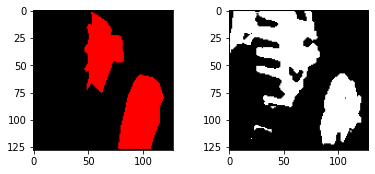

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size,3)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


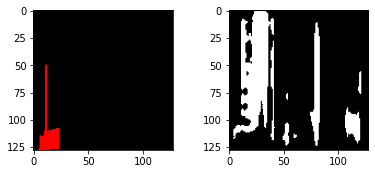

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size,3)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


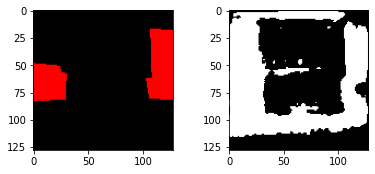

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[2]*255, (image_size, image_size,3)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[2]*255, (image_size, image_size)), cmap="gray")

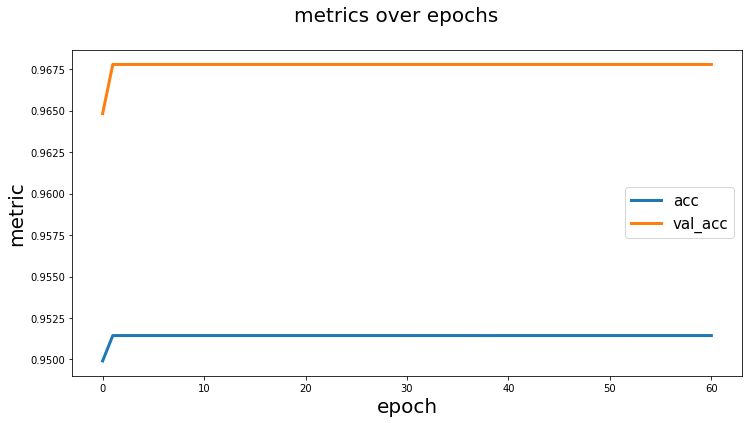

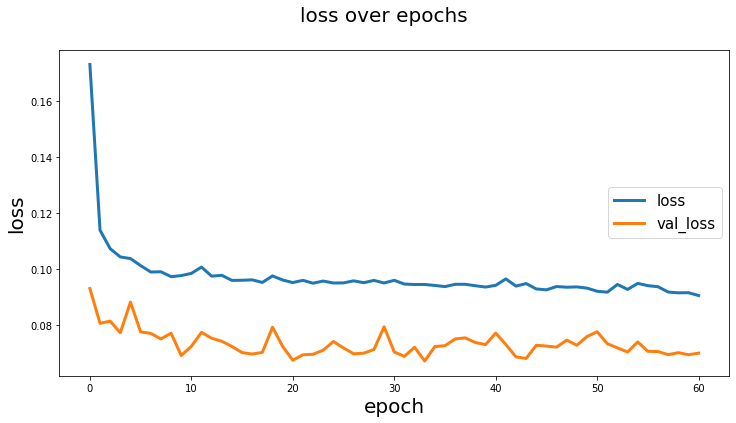

In [ ]:
from keras_unet.utils import plot_segm_history

plot_segm_history(
    history,
    metrics = ['acc', 'val_acc'],
    losses = ['loss','val_loss']
)

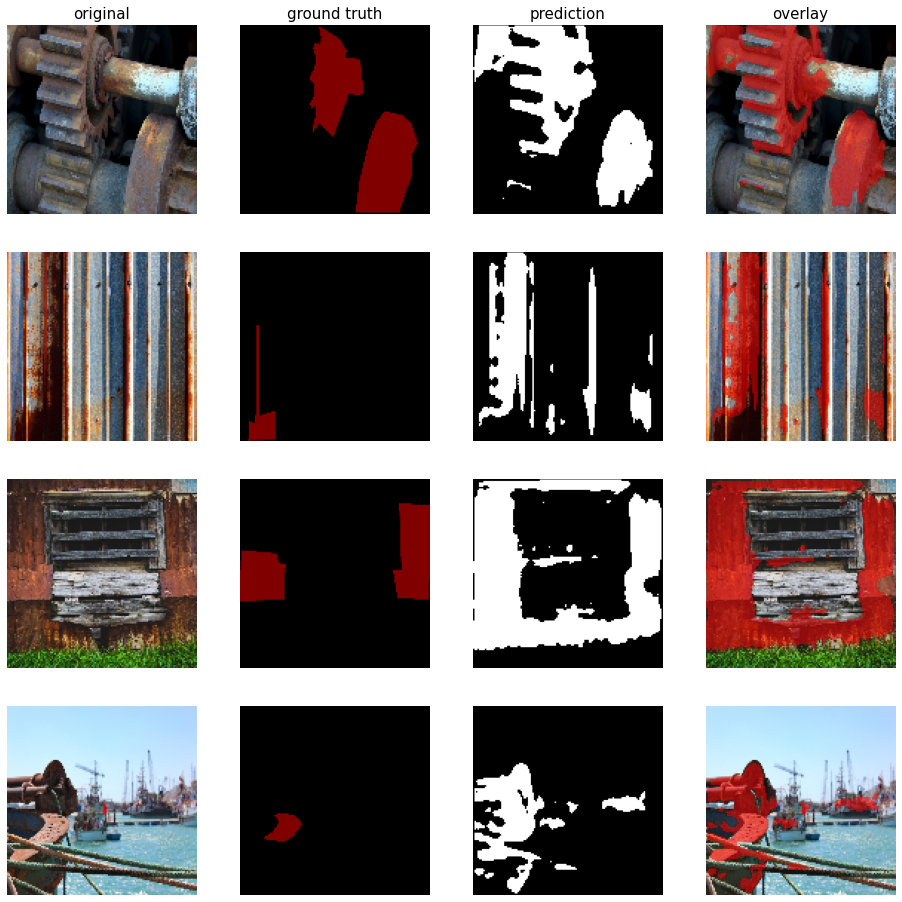

In [ ]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs = x,
    mask_imgs = y,
    pred_imgs = result>0.02,
    nm_img_to_plot=10
)

In [ ]:
test_result = model.predict(x_test) 

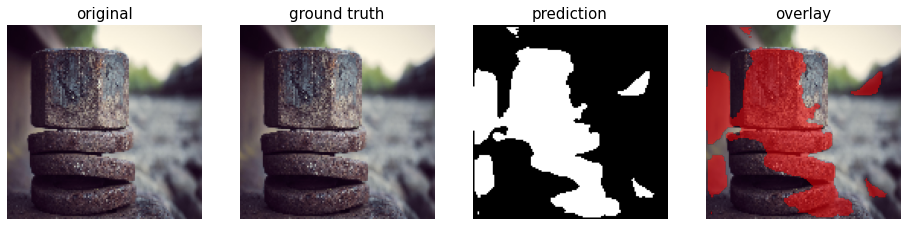

In [ ]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs = x_test,
    mask_imgs = x_test,
    pred_imgs = test_result>0.02,
    nm_img_to_plot=7
)